In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy import stats
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)


In [7]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Using the inspector to print the column names within the 'Measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Using the inspector to print the column names within the 'Station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Mmt = Base.classes.measurement
Sta = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
results = session.query(Mmt.date).order_by(Mmt.date.desc()).first()
results

('2017-08-23')

In [15]:
# Perform a query to retrieve the data and precipitation scores
mmt_past_year = session.query(Mmt.date, Mmt.prcp).filter(Mmt.date >= '2016-08-23').order_by(Mmt.date).all()

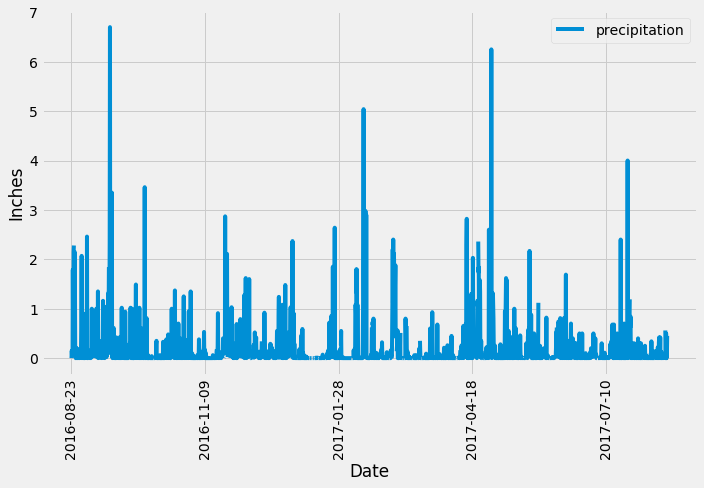

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
mmt_df = pd.DataFrame(mmt_past_year, columns=['Date','precipitation'])
mmt_df.set_index('Date', inplace=True)

# Sort the dataframe by date
mmt_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
mmt_df.plot(kind='line', rot=90, figsize=(10,7), legend=True)
    #xaxis.set_major_locator(plt.MaxNLocator(9))
plt.ylabel('Inches')
plt.tight_layout()
plt.savefig('Images/Precipitation_last_year.png')
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
mmt_df['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

In [18]:
# Design a query to show how many stations are available in this dataset?
# This looks at the Measurement table for unique station ids
session.query(Mmt.station).distinct().count()

9

In [19]:
# This looks at the Station table for number of entries 
# (both queries returned the same value, but had there been a difference, 
# this one would be the more accurate if inactive stations were to be included)
session.query(Sta.id).count()

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sta_counts = session.query(Mmt.station.distinct(),
                            func.count(Mmt.station).label('total')).\
                            group_by(Mmt.station).order_by(desc('total'))

for row in sta_counts:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# complete the query
act_sta_temp = session.query(Mmt.station, Mmt.tobs).filter(Mmt.station=='USC00519281')

# put the query results into a dataframe
act_sta_df = pd.DataFrame(act_sta_temp, columns=['Station','tobs'])

# calculate the statistical information about the temperature
act_sta_df['tobs'].describe()

count    2772.000000
mean       71.663781
std         4.357642
min        54.000000
25%        69.000000
50%        72.000000
75%        74.000000
max        85.000000
Name: tobs, dtype: float64

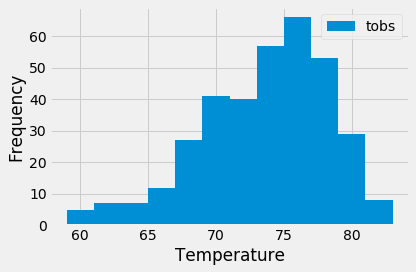

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
double_filt = session.query(Mmt.date, Mmt.station, Mmt.tobs).\
                filter(Mmt.station=='USC00519281').\
                filter(Mmt.date >= '2016-08-23').\
                order_by(Mmt.date).all()
double_filt_df = pd.DataFrame(double_filt, columns=['Date','Station','tobs'])
double_filt_df.plot(kind='hist', legend=True, bins=12)
plt.xlabel('Temperature')
plt.tight_layout()
plt.savefig('Images/Temperature_hist_most_active_sta.png')
plt.show()

## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Mmt.tobs), func.avg(Mmt.tobs), func.max(Mmt.tobs)).\
        filter(Mmt.date >= start_date).filter(Mmt.date <= end_date).all()

# function usage example
print(calc_temps('2016-06-01', '2016-06-30'))

[(64.0, 75.17525773195877, 81.0)]


### Temperature Analysis I & II
* Temperature Analysis I looked at the entire months of June and December
* Temperature Analysis II looks at a programmer specified set of dates

I did the analysis for the part one using the functionality required in the part two, therefore you can say that my specified set of dates for part two is June and December.  I added the t-test at the end to satisfy the final requirement of part one.

In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
year_range = (2010, 2016)
compare_temps_df = pd.DataFrame(columns=['Year', 'JunMin', 'JunAvg', 'JunMax', 'DecMin', 'DecAvg', 'DecMax'])

for year in range(year_range[0], year_range[1]+1):
    june = list(np.ravel(calc_temps(f'{str(year)}-06-01', f'{str(year)}-06-30')))
    dec = list(np.ravel(calc_temps(f'{str(year)}-12-01', f'{str(year)}-12-31')))
    compare_temps_df = compare_temps_df.append({'Year':year,
                             'JunMin': june[0],
                             'JunAvg': june[1],
                             'JunMax': june[2],
                             'DecMin': dec[0],
                             'DecAvg': dec[1],
                             'DecMax': dec[2]}, ignore_index=True)
compare_temps_df['Year'] = compare_temps_df['Year'].astype(int)
compare_temps_df['JunMin'] = compare_temps_df['JunMin'].astype(int)
compare_temps_df['JunMax'] = compare_temps_df['JunMax'].astype(int)
compare_temps_df['DecMin'] = compare_temps_df['DecMin'].astype(int)
compare_temps_df['DecMax'] = compare_temps_df['DecMax'].astype(int)
compare_temps_df

,Year,JunMin,JunAvg,JunMax,DecMin,DecAvg,DecMax
0,2010,67,74.925620,85,58,70.208511,80
1,2011,65,73.938326,82,63,70.820628,77
2,2012,68,74.000000,81,61,71.188073,80
3,2013,66,74.599078,81,63,71.094017,83
4,2014,67,75.027907,84,56,69.896861,81
5,2015,66,74.990148,81,65,73.423913,82
6,2016,64,75.175258,81,60,71.130000,78


In [25]:
compare_temps_df.set_index('Year', inplace=True)
compare_temps_df

,JunMin,JunAvg,JunMax,DecMin,DecAvg,DecMax
Year,,,,,,
2010,67,74.925620,85,58,70.208511,80
2011,65,73.938326,82,63,70.820628,77
2012,68,74.000000,81,61,71.188073,80
2013,66,74.599078,81,63,71.094017,83
2014,67,75.027907,84,56,69.896861,81
2015,66,74.990148,81,65,73.423913,82
2016,64,75.175258,81,60,71.130000,78


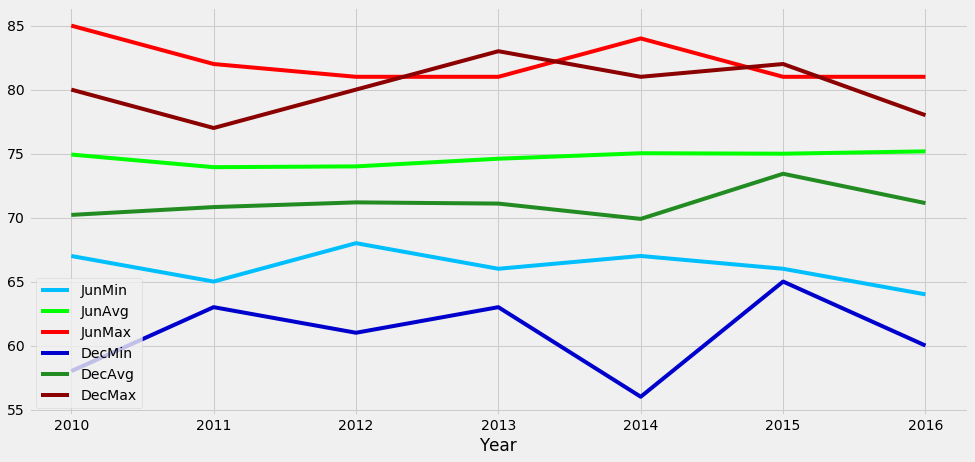

In [26]:
# This line chart shows the changing values and the relationship between the 
# June and December values well with color choices helping with that visualization
my_colors = ['#00BFFF','#00FF00','#FF0000','#0000CD','#228B22','#8B0000']
compare_temps_df.plot(kind='line', figsize=(15,7), color=my_colors)
plt.show()

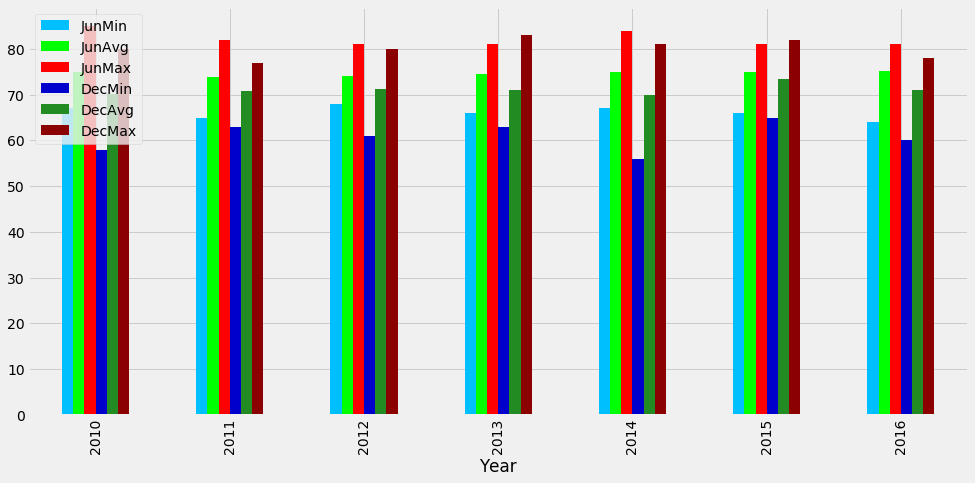

In [27]:
# This bar chart is not as helpful as the related values are too spread out
my_colors = ['#00BFFF','#00FF00','#FF0000','#0000CD','#228B22','#8B0000']
compare_temps_df.plot(kind='bar', figsize=(15,7), color=my_colors)
plt.show()

In [28]:
compare_temps_df

,JunMin,JunAvg,JunMax,DecMin,DecAvg,DecMax
Year,,,,,,
2010,67,74.925620,85,58,70.208511,80
2011,65,73.938326,82,63,70.820628,77
2012,68,74.000000,81,61,71.188073,80
2013,66,74.599078,81,63,71.094017,83
2014,67,75.027907,84,56,69.896861,81
2015,66,74.990148,81,65,73.423913,82
2016,64,75.175258,81,60,71.130000,78


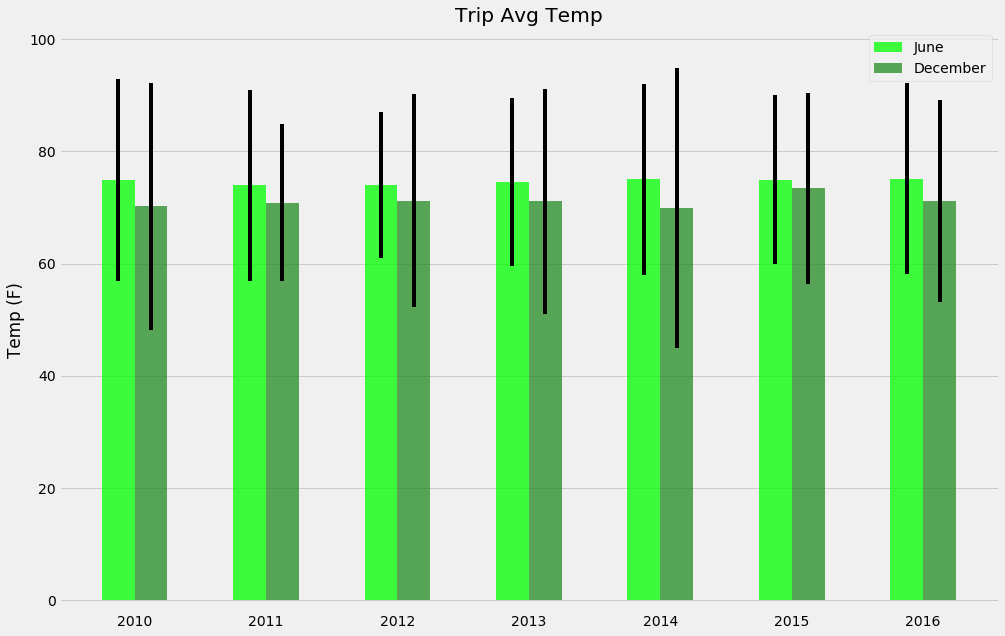

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
jun_error = []
dec_error = []

jun_max_list = compare_temps_df['JunMax'].to_list()
jun_min_list = compare_temps_df['JunMin'].to_list()
dec_max_list = compare_temps_df['DecMax'].to_list()
dec_min_list = compare_temps_df['DecMin'].to_list()

for i in range(0,len(jun_max_list)):
    jun_error.append(jun_max_list[i] - jun_min_list[i])
    dec_error.append(dec_max_list[i] - dec_min_list[i])

plt.figure(figsize=(15,10))

barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(compare_temps_df.index))
r2 = [x + barWidth for x in r1]

plt.bar(r1,height=compare_temps_df['JunAvg'], alpha=0.75, width=barWidth, color='#00FF00', yerr=jun_error, label='June')
plt.bar(r2,height=compare_temps_df['DecAvg'], alpha=0.75, width=barWidth, color='#228B22', yerr=dec_error, label='December')
plt.xticks([r + barWidth/2 for r in range(len(compare_temps_df.index))], compare_temps_df.index)
plt.ylim(-2,102)
plt.grid(axis='x')
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.legend()
plt.show()

##### Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
The above p-value is 0.00023 which is less that the o.o5 required, therefore, the difference is statistically significant

##### Will you use a paired t-test, or an unpaired t-test? Why?
A paired t-test was used because the two sets of means were the same data set at different time frames.

In [30]:
t2, p2 = stats.ttest_rel(compare_temps_df['JunAvg'],compare_temps_df['DecAvg'])
print(t2, p2)

7.780060705002921 0.00023742611093245777


### Daily Rainfall Average

In [49]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-06-01'
end_date = '2016-06-30'
sta_counts = session.query(func.sum(Mmt.prcp).label('total'), Sta.name, 
                            Sta.latitude, Sta.longitude, Sta.elevation).\
                            group_by(Mmt.station).order_by(desc('total')).\
                            filter(Mmt.date >= start_date).filter(Mmt.date <= end_date).\
                            join(Sta, Sta.station == Mmt.station)

station_precip_df = pd.DataFrame(columns=['Total Precip', 'Station Name', 'Latitude', 'Longitude', 'Elevation'])

for row in sta_counts:
    row_list = list(np.ravel(row))
    station_precip_df = station_precip_df.append({'Total Precip':row_list[0],
                                                  'Station Name':row_list[1],
                                                  'Latitude':row_list[2],
                                                  'Longitude':row_list[3],
                                                  'Elevation':row_list[4]
                                                    }, ignore_index=True)
station_precip_df

,Total Precip,Station Name,Latitude,Longitude,Elevation
0,16.83,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
1,8.58,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9
2,5.189999999999998,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
3,2.7999999999999994,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
4,2.4599999999999995,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,0.6,"PEARL CITY, HI US",21.3934,-157.9751,11.9
6,0.27,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0


In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Mmt.tobs), func.avg(Mmt.tobs), func.max(Mmt.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Mmt.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [77]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2016-06-01'
end_date = '2016-06-30'

# Use the start and end date to create a range of dates
start = dt.datetime.strptime(start_date, '%Y-%m-%d')
end = dt.datetime.strptime(end_date, '%Y-%m-%d')

dates_list = []
for n in range(int ((end - start).days+1)):
    date = start + dt.timedelta(n)
    dates_list.append(str(dt.datetime.strftime(date, '%m-%d')))

# Loop through the list of %m-%d strings and calculate the normals for each date
date_normals = []
for date in dates_list:
    date_normals.append(daily_normals(date))

date_normals

[[(64.0, 74.6140350877193, 81.0)],
 [(65.0, 74.4, 81.0)],
 [(65.0, 74.03448275862068, 80.0)],
 [(65.0, 73.81818181818181, 81.0)],
 [(68.0, 74.85454545454546, 81.0)],
 [(70.0, 75.17543859649123, 80.0)],
 [(68.0, 75.07142857142857, 81.0)],
 [(70.0, 75.58620689655173, 81.0)],
 [(69.0, 75.15254237288136, 81.0)],
 [(68.0, 75.14285714285714, 81.0)],
 [(69.0, 76.01960784313725, 84.0)],
 [(66.0, 75.66666666666667, 83.0)],
 [(68.0, 75.66666666666667, 81.0)],
 [(69.0, 75.62711864406779, 81.0)],
 [(67.0, 75.40350877192982, 81.0)],
 [(69.0, 75.41379310344827, 81.0)],
 [(68.0, 74.59322033898304, 81.0)],
 [(69.0, 74.60344827586206, 80.0)],
 [(70.0, 75.44067796610169, 82.0)],
 [(68.0, 73.96491228070175, 85.0)],
 [(68.0, 74.75862068965517, 82.0)],
 [(69.0, 75.15789473684211, 81.0)],
 [(68.0, 74.54385964912281, 80.0)],
 [(68.0, 74.96428571428571, 84.0)],
 [(68.0, 74.10344827586206, 80.0)],
 [(67.0, 74.21428571428571, 82.0)],
 [(66.0, 75.01785714285714, 81.0)],
 [(69.0, 74.88679245283019, 80.0)],
 [(67.

In [95]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(columns=['Date', 'TempMin', 'TempAvg', 'TempMax'])

for row in date_normals:
    row_list = list(np.ravel(row))
    normals_df = normals_df.append({'TempMin':row_list[0], 
                                                  'TempAvg':row_list[1], 
                                                  'TempMax':row_list[2]
                                                    }, ignore_index=True)
normals_df['Date']=dates_list
normals_df.set_index('Date', inplace=True)
normals_df

,TempMin,TempAvg,TempMax
Date,,,
06-01,64.0,74.614035,81.0
06-02,65.0,74.400000,81.0
06-03,65.0,74.034483,80.0
06-04,65.0,73.818182,81.0
06-05,68.0,74.854545,81.0
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0


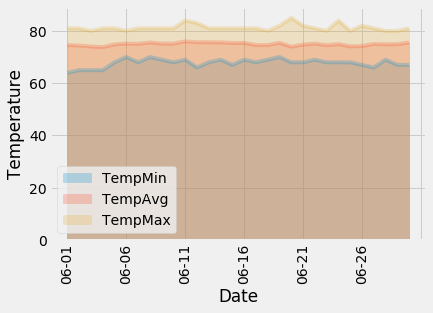

In [96]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, rot=90, alpha=0.25)
plt.ylabel('Temperature')
plt.show()